Stein Unbiased Risk Estimator
=============================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour uses the Stein Unbiased Risk Estimator (SURE) to optimize the
value of parameters in denoising algorithms.

In [9]:
using PyPlot
using NtToolBox
#using Autoreload
#arequire("NtToolBox")

Denoising and SURE
------------------
We consider a simple generative model of noisy images $F = f_0+W$
where $f_0 \in \RR^N$ is a deterministic image of $N$ pixels, and
$W$ is a Gaussian white noise distributed according to $\Nn(0,\si^2
\text{Id}_N)$, where $\si^2$ is the variance of noise.


The goal of denoising is to define an estimator $h(F)$ of
$f_0$ that depends only on $F$,
where $h : \RR^N \rightarrow \RR^N$ is a potentially non-linear
mapping.


Note that while $f_0$ is a deterministic image, both $F$ and $h(F)$
are random variables (hence the capital letters).


The goal of denoising is to reduce as much as possible the denoising
error given some prior knowledge on the (unknown) image $f_0$.
A mathematical way to measure this error is to bound the
quadratic risk $\EE_W(\norm{h(F) - f_0}^2)$, where the expectation is computed
with respect to the distribution of the noise $W$


For real life applications, one does not have access to the underlying
image $f_0$. In this tour, we however assume that $f_0$ is known, and
$f = f_0 + w\in \RR^N$ is generated using a single realization of the noise $w$
that is drawn from $W$. We define the estimated deterministic image as
$h(f)$ which is a realization of the random vector
$h(F)$.


Number $N = n \times n$ of pixels.

In [10]:
n = 128*2
N = n^2;

First we load an image $f \in \RR^N$ where $N=n \times n$ is the number of pixels.

In [11]:
f0 = load_image("NtToolBox/src/data/hibiscus.png", n);

Display it.

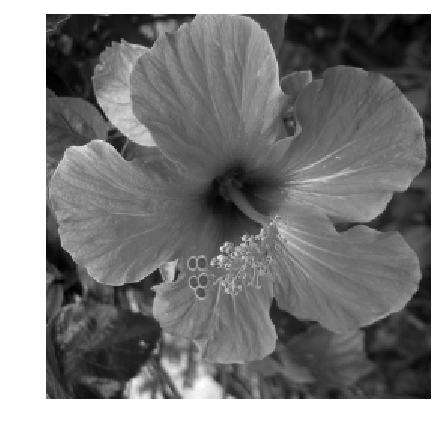

In [12]:
figure(figsize = (5, 5))
imageplot(f0)

Standard deviation $\si$ of the noise.

In [13]:
sigma = .08;

Then we add Gaussian noise $w$ to obtain $f=f_0+w$.

In [14]:
using Distributions
f = f0 .+ sigma.*rand(Normal(), n, n);

Display the noisy image. Note the use of the clamp function to force the result to be in $[0,1]$ to avoid a loss of contrast of the display.

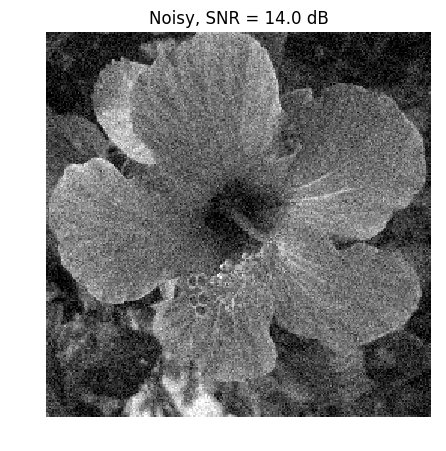

PyObject <matplotlib.text.Text object at 0x330d23290>

In [15]:
figure(figsize = (5, 5))
imageplot(clamP(f), @sprintf("Noisy, SNR = %.1f dB", snr(f0, f)))

The Stein Unbiased Risk Estimator (SURE) associated to the mapping $h$
is defined as

$$ \text{SURE}(f) = -N\si^2 + \norm{h(f)-f}^2 + 2\si^2 \text{df}(f) $$

where df stands for _degree of freedom,_ and is defined as

$$ \text{df}(f) = \text{div} h(f) = \sum_i \pd{h}{f_i}(f). $$


It has been introduced in:


Stein, Charles M. (November 1981).
"Estimation of the Mean of a Multivariate Normal Distribution".
The Annals of Statistics 9 (6): 1135-1151.


And it has been applied to wavelet-based non-linear denoising in:


Donoho, David L.; Iain M. Johnstone (December 1995).
"Adapting to Unknown Smoothness via Wavelet Shrinkage".
Journal of the American Statistical Association (Journal of the American Statistical Association,
Vol. 90, No. 432) 90 (432): 1200-1244.


If the mapping $f \mapsto h(f)$ is differentiable outside a set of
zero measure (or more generally weakly differentiable),
then SURE defines an unbiased estimate of the quadratic risk :

$$ \EE_W(\text{SURE}(F)) = \EE_W( \norm{f_0-h(F)}^2 ). $$

This is especially useful, since the evaluation of SURE does not
necessitate the knowledge of the clean signal $f_0$ (but note however
that it requires the knowledge of the noise level $\si$).


In practice, one replaces $\text{SURE}(F)$ from its empirical
evaluation $\text{SURE}(f)$ on a single realization $f$.
One can then minimize $\text{SURE}(f)$ with respect to a parameter
$\la$ that parameterizes the denoiser $h=h_\la$.


Linear Denoising SURE
---------------------
We consider a translation-invariant linear denoising operator, which is
thus a convolution

$$ h(f) = g \star h $$

where $g \in \RR^N$ is a low pass kernel, and $\star$ denotes the
periodic 2-D convolution.


Since we use periodic boundary condition, we compute the
convolution as a multiplication over the Fourier domain.

$$ \forall \om, \quad \hat h(f)(\om) = \hat f(\om) \hat g(\om) $$

where $\hat g(\om)$ is the frequency $\om$ of the discrete 2-D
Fourier transform of $g$ (computed using the pylab function fft2 from the pylab package).

In [16]:
convol = (f, g) -> real(plan_ifft((plan_fft(f)*f).*(plan_fft(g)*g))
*((plan_fft(f)*f).*(plan_fft(g)*g)))

(::#1) (generic function with 1 method)

We define a parameteric kernel $g_\la$ parameterized by its bandwidth
$\la>0$. We use here a Gaussian kernel

$$ g_\la(a) = \frac{1}{Z_\la} e^{ -\frac{\norm{a}}{2 \la^2} } $$
where $Z_\la$ ensures that $\sum_a g_\la(a) = 1$.

In [17]:
include("ndgrid.jl")
normalize = f -> f./sum(f)
x = [collect(0 : Base.div(n, 2)); collect(-Base.div(n, 2) + 1 : -1)]
(Y, X) = meshgrid(x, x)
g = lambd -> normalize(exp(-(X.^2 .+ Y.^2)/(2*lambd^2)))

LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/ndgrid.jl

Define our denoising operator $h=h_\la$ (we make explicit the
dependency on $\la$):
$$ h_\la(f) = g_\la \star f. $$

In [18]:
h = (f, lambd) -> convol(f, g(lambd))

(::#3) (generic function with 1 method)

Example of denoising result.

In [19]:
lambd = 1.5

figure(figsize = (5, 5))
imageplot(clamP(h(f, lambd)))

LoadError: UndefVarError: g not defined

For linear operator, the dregree of freedom is equal to the trace of the operator, and
thus in our case it is equal to the sum of the Fourier transform
$$ \text{df}_\la(f) = \text{tr}(h_\la) = \sum_{\om} \hat g_\la(\om) $$
Note that we have made explicit the dependency of df with respect
to $\la$. Note also that df$(f)$ actually not actually depend on $f$.

In [20]:
df = lambd -> real(sum(plan_fft(g(lambd))*g(lambd)))

(::#5) (generic function with 1 method)

We can now define the SURE=SURE$_\la$ operator, as a function of $f, h(f),
\lambda$.

In [21]:
SURE = (f ,hf, lambd) -> -N*sigma^2 + vecnorm(hf - f)^2 + 2*sigma^2*df(lambd) # vecnorm is for Frobenius norm

(::#7) (generic function with 1 method)

__Exercise 1__

For a given $\lambda$, display the histogram of the repartition of
the quadratic error $\norm{y-h(y)}^2$ and of $\text{SURE}(y)$.
Compute these repartition using Monte-Carlo simulation (you need to
generate lots of different realization of the noise $W$).
Display in particular the location of the mean of these quantities.

In [22]:
include("Exos\\denoisingadv_9_sure\\exo1.jl") #It takes time to run

# ntrials = 100
# nlaunch = 20
# E0 = []
# E = []

# for i in 1:nlaunch

#     f = repeat(f0, inner = [1, 1, ntrials]) + sigma.*rand(Normal(), n, n, ntrials)
#     hf = h(f, lambd)

#     #quadratic error
#     e = sum((hf - repeat(f0, inner = [1, 1, ntrials])).^2, (1, 2))
#     E0 = [E0; e[:]]

#     #sure error
#     e = -N*sigma^2 + sum((hf - f).^2, (1, 2)) + 2*sigma^2*df(lambd)
#     E = [E; e[:]]
# end


# v_true = mean(E0)
# v_sure = mean(E)
# a = v_true - 8*stdm(E0, mean(E0))
# b = v_true + 8*stdm(E0, mean(E0))
# t = linspace(a, b, 31)
# mybar = e -> hist(e[collect((i > a) & (i < b) for i in E0)], t)

# figure(figsize = (10, 7))

# subplot(2,1,1)
# s = mybar(E0)[2]
# s = [s; 0]
# bar(t[1 : end], s, width = (b-a)/31, color = "darkblue", edgecolor = "white")
# axvline(v_true, color = "red", linewidth = 3)

# subplot(2,1,2)
# s = mybar(E)[2]
# s = [s; 0]
# bar(t[1 : end], s, width = (b-a)/31, color = "darkblue",edgecolor = "white")
# axvline(v_sure, color = "red", linewidth = 3)

# show()



LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/Exos\denoisingadv_9_sure\exo1.jl

In [23]:
## Insert your code here.

In practice, the SURE is used to set up the value of $\la$ from a
single realization $f=f_0+w$, by minimizing $\text{SURE}_\la(f)$.

__Exercise 2__

Compute, for a single realization $f=f_0+w$, the evolution
of

$$ E(\la) = \text{SURE}_\la(f) \qandq E_0(\lambda) = \norm{f-h_\la(f)}^2 $$
as a function of $\lambda$.

In [24]:
include("Exos\\denoisingadv_9_sure\\exo2.jl")

LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/Exos\denoisingadv_9_sure\exo2.jl

In [25]:
## Insert your code here.

__Exercise 3__

Display the best denoising result $h_{\la^*}(f)$
where
$$\la^* = \uargmin{\la} \text{SURE}_\la(f) $$

In [26]:
include("Exos\\denoisingadv_9_sure\\exo3.jl")

LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/Exos\denoisingadv_9_sure\exo3.jl

In [27]:
## Insert your code here.

Soft Thresholding SURE
----------------------
In order to enhance the denoising results for piecewise regular signal
and image, it is possible to use non-linear thresholding in an orthogonal wavelet
basis $ \Bb = \{ \psi_m \}_{m} $ where $\psi_m \in \RR^N$ is a wavelet element.


Re-generate a noisy image.

In [28]:
f = f0 + sigma.*rand(Normal(), n, n);

The soft-thresholding estimator thus reads
$$ h_\la(f) = \sum_m s_\la( \dotp{f}{\psi_m} ) \psi_m
      \qwhereq s_\la(\al) = \max\pa{0, 1-\frac{\la}{\abs{\al}}} \al. $$
It can be conveniently written as
$$ h_\la = \Ww^* \circ S_\la \circ \Ww $$
where $\Ww$ and $\Ww^*$ are forward and inverse wavelet transform
$$ \Ww(f) = ( \dotp{f}{\psi_m} )_m \qandq
      \Ww^*(x) = \sum_m x_m \psi_m, $$
and $ S_\la $ is the diagonal soft thresholding operator
$$ S_\la(x) = ( s_\la(x_m) )_m. $$


Define the wavelet transform and its inverse.

In [29]:
h_daub = compute_wavelet_filter("Daubechies", 4)
W  = f1 -> NtToolBox.perform_wavortho_transf(f1,0,+1,h_daub)
Ws = x -> NtToolBox.perform_wavortho_transf(x,0,-1,h_daub)

(::#11) (generic function with 1 method)

Display the wavelet transform $\Ww(f_0)$ of the original image.

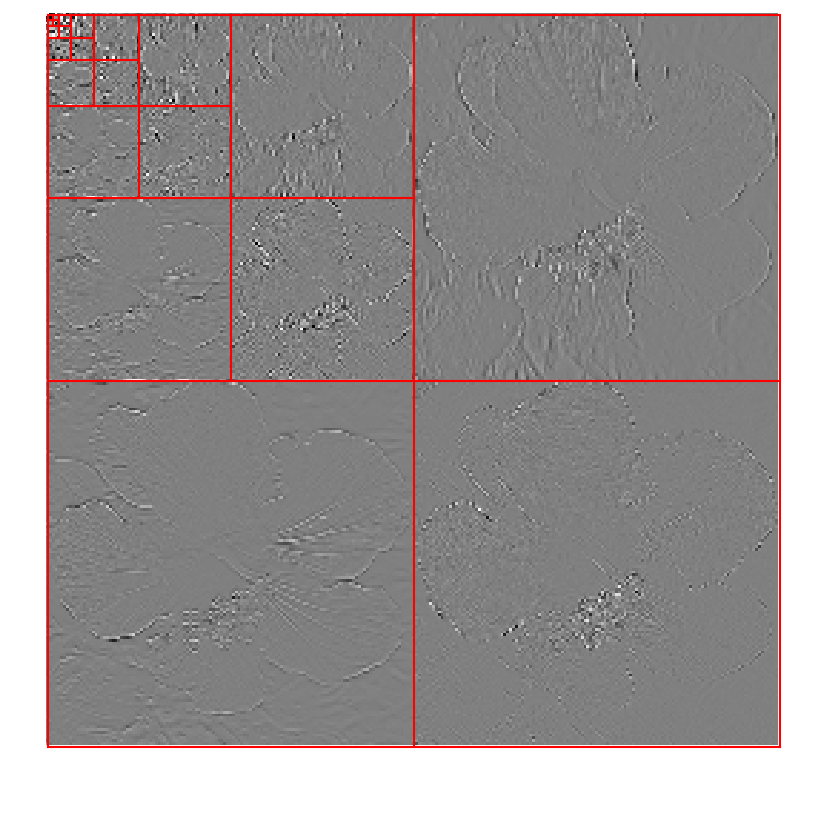

In [30]:
figure(figsize = (10,10))
plot_wavelet(W(f0), 1)
show()

Define the soft thresholding operator.

In [31]:
S = (x, lambd) -> max(0, 1 - lambd./max(1e-9, abs(x)) ) .* x;

Define the denoising operator.

In [32]:
h = (f1, lambd) -> Ws(S(W(f1), lambd));

Example of denoising result.

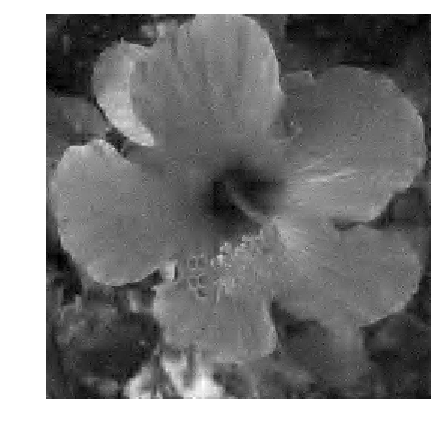

In [33]:
lambd = 3*sigma/2

figure(figsize = (5, 5))
imageplot(clamP(h(f,lambd)))

Since $Ww$ is an orthogonal transform, one has
$$ \text{df}(f) = \text{div}( S_\la )( \Ww(f) )
      = \sum_m s_\la'( \dotp{f}{\psi_m} ) = \norm{\Ww(h(f))}_0  $$
where $ s_\la' $ is the derivative of the 1-D function $s_\la$, and
$\norm{\cdot}_0$ is the $\ell^0$ pseudo-norm
$$ \norm{x}_0 = \abs{ \enscond{m}{x_m \neq 0} }. $$


To summarize, the degree of freedom is equal to the number of non-zero
coefficients in the wavelet coefficients of $h(f)$.

In [34]:
df = (hf, lambd) -> sum(abs(W(hf)) .> 1e-8);

We can now define the SURE operator, as a function of $f, h(f),
\lambda$.

In [35]:
SURE = (f, hf, lambd) -> -N*sigma^2 + vecnorm(hf - f)^2 + 2*sigma^2*df(hf, lambd);

__Exercise 4__

For a given $\lambda$, display the histogram of the repartition of
the quadratic error $\norm{y-h(y)}^2$ and of $\text{SURE}(y)$.
Compute these repartition using Monte-Carlo simulation (you need to
generate lots of different realization of the noise $W$).
Display in particular the location of the mean of these quantities.
_Hint:_ you can do the computation directly over the wavelet domain,
i.e. consider that the noise is added to the wavelet transform.

In [36]:
run -i nt_solutions/denoisingadv_9_sure/exo4

LoadError: syntax: extra token "nt_solutions" after end of expression

In [37]:
## Insert your code here.

__Exercise 5__

Compute, for a single realization $f=f_0+w$, the evolution
of

$$ E(\la) = \text{SURE}_\la(f) \qandq E_0(\lambda) = \norm{f-h_\la(f)}^2 $$
as a function of $\lambda$.

In [38]:
include("Exos\\denoisingadv_9_sure\\exo5.jl")

LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/Exos\denoisingadv_9_sure\exo5.jl

In [39]:
## Insert your code here.

__Exercise 6__

Display the best denoising result $h_{\la^*}(f)$
where
$$\la^* = \uargmin{\la} \text{SURE}_\la(f) $$

In [40]:
include("Exos\\denoisingadv_9_sure\\exo6.jl")

LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/Exos\denoisingadv_9_sure\exo6.jl

In [41]:
## Insert your code here.

Block-soft Thresholding SURE
----------------------------
To improve the result of soft thresholding, it is possible to threshold
blocks of coefficients.


We define a partition $ \{1,\ldots,N\} = \cup_k b_k $ of the set of wavelet
coefficient indexes. The block thresholding is defined as

$$ h_\la(f) = \sum_k \sum_{m \in b_k} a_\la( e_k ) \dotp{f}{\psi_m} \psi_m
      \qwhereq
      e_k = \sum_{m \in b_k} \abs{\dotp{f}{\psi_m}}^2,
$$
where we use the James-Stein attenuation threshold
$$
      a_\la(e) = \max\pa{ 0, 1 - \frac{\la^2}{e^2} }.
$$


The block size $q$.

In [42]:
q = 4;

A function to extract blocks.

In [43]:
include("ndgrid.jl")

(X, Y, dX, dY) = ndgrid(1:q:n-q+1, 1:q:n-q+1, 0:q-1, 0:q-1)
I = X + dX + (Y + dY - 1).*n
I

for i in 1:Base.div(n, q)
    for j in Base.div(n, q)
        I[i,j, :, :] = transpose(I[i,j, :, :])
    end
end


blocks = fw -> fw[I]





LoadError: could not open file /Users/gpeyre/Dropbox/github/numerical-tours/julia/ndgrid.jl

A function to reconstruct an image from blocks.

In [44]:
function assign(M, I, H)
    M_temp = M
    M_temp[I] = H
    return reshape(M_temp, n,n)
end

unblock = H -> assign(zeros(n,n), I, H)

(::#21) (generic function with 1 method)

Compute the average energy of each block, and duplicate.

In [45]:
function energy(H)
    H_tmp = copy(H)
    for i in 1:Base.div(n, q)
        for j in 1:Base.div(n, q)
            H_tmp[i, j, :, :] = mean(H_tmp[i, j, :, :].^2).*ones(q, q)
        end
    end
    return H_tmp
end

energy (generic function with 1 method)

Threshold the blocks. We use here a Stein block thresholding.
All values within a block are atenuated by the same factor.

In [46]:
S = (H,lambda) -> max(1 - lambda^2 ./ energy(H), 0) .* H

(::#23) (generic function with 1 method)

Block thresholding estimator $h_\lambda(f)$.

In [47]:
h = (f, lambd) -> Ws(unblock(S(blocks(W(f)), lambd)))

(::#25) (generic function with 1 method)

Example of block denoising.

In [48]:
lambd = 1.1*sigma

figure(figsize = (5, 5))
imageplot(clamP(h(f, lambd)))


LoadError: UndefVarError: blocks not defined

Since the block-thresholding operates in a block diagonal manner over the
wavelet coefficients, it degree of freedom is a sum of the divergence of
each block James-Stein operator
$$
  \text{df}(f) = \sum_{ e_k > \la^2 } \text{tr}( \partial \phi (a_k) )
$$
where $ a_k = (\dotp{f}{\psi_m})_{m \in b_k} $ is the set of coefficients
inside a block, that satisfies $\norm{a_k}=e_k$, and
where
$$ \phi(a) = \pa{ 1 - \frac{\la^2}{\norm{a}^2} } a. $$
One can compute explicitely the derivative of $\phi$
$$ \partial \phi(a) = \pa{ 1 - \frac{\la^2}{\norm{a}^2} } \text{Id} + 2 \frac{\la^2}{\norm{a}^2} \Pi_a $$
where $\Pi_a$ is the orthogonal projector on $a$.


This gives the folowing formula for the degree of freedom
$$
  \text{df}(f) = \norm{\Ww(h_\la(f))}_0
+ \sum_{ e_k > \la^2 }
  \frac{\la^2}{e_k} (2-\abs{b_k}).
$$
One can note that the degree of freedom differs from the one of the soft thresholding
(it is not in general an integer).